## Import the necessary libraries

In [1]:
from nn import nn, preprocess, io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Read in the positive and negative sequence files

In [2]:
pos_seqs = io.read_text_file("./data/rap1-lieb-positives.txt")
neg_seqs = io.read_fasta_file("./data/yeast-upstream-1k-negative.fa")

## Split the data

The positive sequences are 17 nucleotides in length, whereas the negative sequences are 1,000 nucleotides each. We will therefore split the negative sequences into 17 nucleotide fragments, which therefore accounts for sequence length discrepancies.

In [3]:
target_length = len(pos_seqs[0])
negatives_split = []
for seq in neg_seqs:
    split = []
    for i in range(int(len(seq)/target_length)):
        split.append(seq[i*target_length:(i+1)*target_length])
    negatives_split += split

Now we just concatenate the two groups of sequences into our X feature matrix. Additionally, we create a target vector with 0s and 1s (negative seqs and positive seqs, respectively). The amount of 0s and 1s corresponds to the number of negative and positive sequences.

In [4]:
X = pos_seqs + negatives_split
y = np.concatenate([np.ones(len(pos_seqs)), np.zeros(len(negatives_split))]).tolist()

## Implement upsampling procedure

The implemented scheme takes the less predominant label and samples from it with replacement. It samples until it's the same size as the predominant label. This upsamples the minority label to increase its signal and balance the data. We then sample the corresponding sequences using these balanced labels.

In [5]:
X, y = preprocess.sample_seqs(X, y)

## One-Hot Encoding procedure

This scheme implements a dictionary with the numerical encodings for each nucleotide. It iterates over all of the sequences given as input, and applies a list comprehension to each character in the string it's reading, creating a numpy array with the values from the nucleotide encoding dictionary. 

In [6]:
X = preprocess.one_hot_encode_seqs(X)

## Split the data

Not much to say, this is the Scikit-Learn implementation for splitting data, most commonly for ML applications. I used a random state of 42 because it's the answer to the ultimate question of life, the universe, and everything, and a standard split of 70/30 (training/test).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
y_train = np.array(y_train) # Convert the target vectors to numpy arrays to interact with the neural network
y_test = np.array(y_test)

## Create instance of TF Classifier

First layer has 68 neurons because we're using 17 nucleotide sequences and we're dealing with the 4 nucleotides that make up the genetic code. The second layer has 34 neurons because this is a binary classification problem. And finally, we have one output, where we essentially get a 0 or 1 (not a TF binding site, or yes TF binding site, respectively). Each layer has a sigmoid activation function because this is all in all a binary classification problem, and this function tackles this problem well.

The learning rate is super small because otherwise the loss starts increasing with each epoch. While this means that the weights are updated very little for each iteration, nevertheless it appears that the model converges in terms of loss (once we look at the results).

The batch size is 2,000 to speed up training, as otherwise the model took significantly longer to fit to the training data.

Finally, I chose the binary cross entropy loss function because its utility for classifiers is well-documented (see for example this work by Ruby et al: https://www.researchgate.net/profile/Vamsidhar-Yendapalli/publication/344854379_Binary_cross_entropy_with_deep_learning_technique_for_Image_classification/links/5f93eed692851c14bce1ac68/Binary-cross-entropy-with-deep-learning-technique-for-Image-classification.pdf). 

In [9]:
arch = [{'input_dim': 68, 'output_dim': 34, 'activation': 'sigmoid'},
       {'input_dim': 34, 'output_dim': 1, 'activation': 'sigmoid'}] # output layer

lr = 0.00001 
n_seed = 42
batch_size = 2000 
epochs = 100
loss_fun = 'bce'

tf_clf_nn = nn.NeuralNetwork(arch, lr, n_seed, batch_size, epochs, loss_fun)

In [10]:
train_loss, val_loss = tf_clf_nn.fit(X_train, y_train, X_test, y_test)

## Plot the training and validation loss per epoch

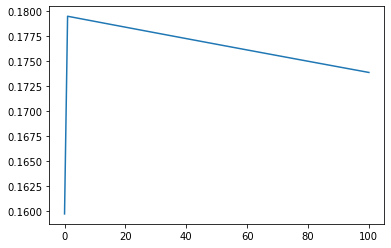

In [11]:
plt.plot(train_loss)
plt.show()

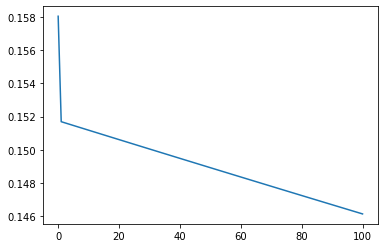

In [12]:
plt.plot(val_loss)
plt.show()

In [13]:
preds = tf_clf_nn.predict(X_test)

In [14]:
y_test

array([0., 1., 1., ..., 1., 0., 0.])

## Model Accuracy

In [15]:
flattened_preds = preds.flatten()
np.sum(np.isclose(flattened_preds, y_test))/len(y_test) # Not really working

0.0

In [16]:
flattened_preds

array([0.43355702, 0.42147828, 0.42275609, ..., 0.42042644, 0.42626723,
       0.44931526])